### Titanic - Machine Learning from Disaster 
The data has been split into two groups:
    
- training set (train.csv)
- test set (test.csv)

The training set should be used to build your machine learning models. For the training set, we provide the outcome (also known as the “ground truth”) for each passenger. Your model will be based on “features” like passengers’ gender and class. You can also use feature engineering to create new features.

The test set should be used to see how well your model performs on unseen data. For the test set, we do not provide the ground truth for each passenger. It is your job to predict these outcomes. For each passenger in the test set, use the model you trained to predict whether or not they survived the sinking of the Titanic.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()

### Data Dictionary: Variable	Definition	Key
- survival: Survival; 0 = No, 1 = Yes
- pclass: Ticket class; 1 = 1st, 2 = 2nd, 3 = 3rd
- sex: Sex
- Age: Age in years
- sibsp: # of siblings / spouses aboard the Titanic
- parch: # of parents / children aboard the Titanic
- ticket: Ticket number
- fare: Passenger fare
- cabin: Cabin number
- embarked: Port of Embarkation; C = Cherbourg, Q = Queenstown, S = Southampton

In [12]:
training_df = pd.read_csv('titanic/train.csv')
training_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [13]:
training_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### Information to based on summarized data
In the training data:
- There are 891 passengers 
- Only 714 passengers have an age 
- Ticket column is a bit strange, sometimes numeric, sometimes alphanumeric, need to organize somehow, maybe create new column
- Will need to convert Sex column into numeric

Some possible correlations to be made with this data set:
- ticket class correlated to fare
- cabin number correlated to ticket class


In [21]:
### To handle ticket column, substring if starts with letter and separate by a space? 

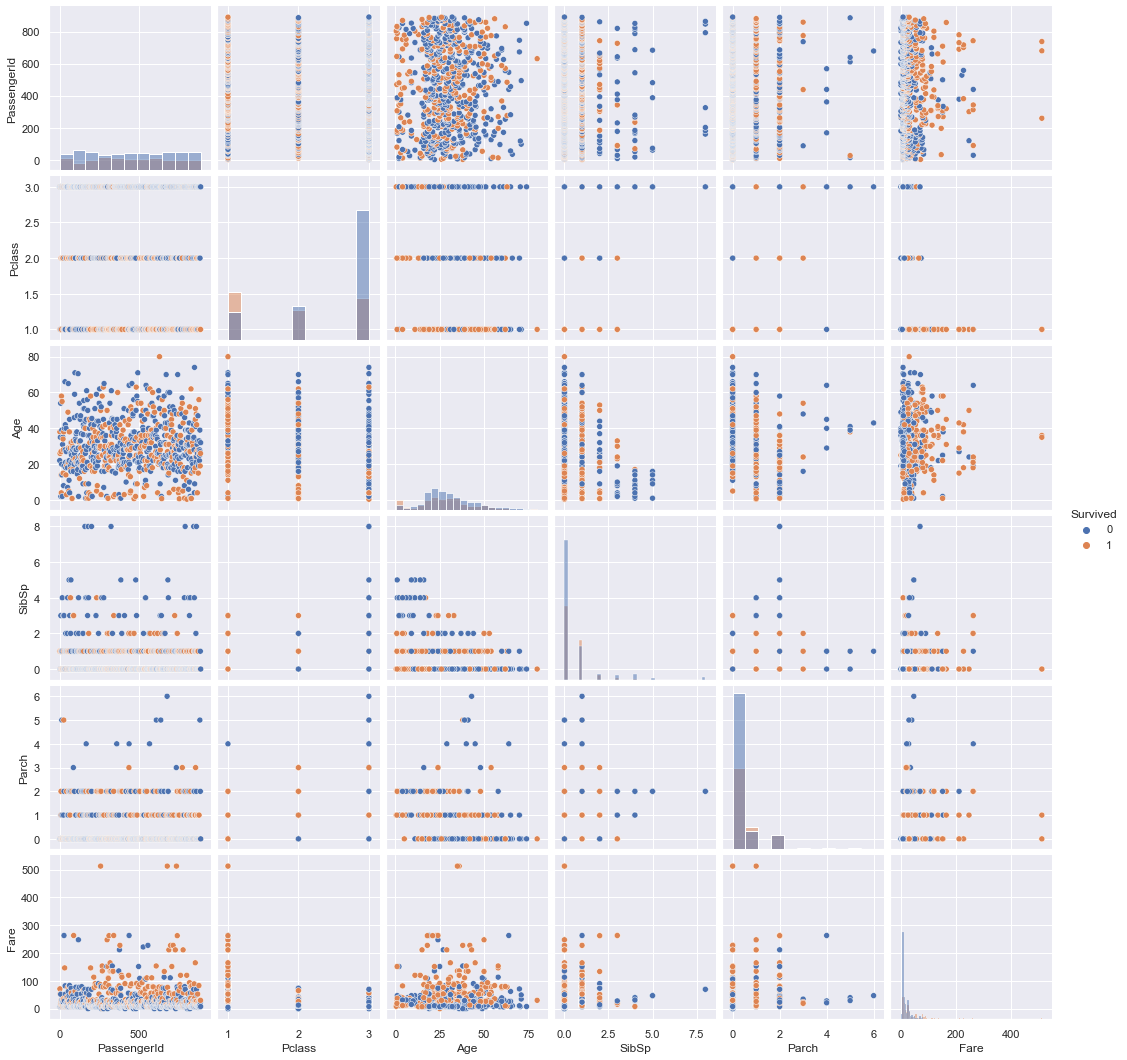

In [17]:
sns.pairplot(training_df, hue = 'Survived', diag_kind="hist")

### Nothing obviously striking in the pair plot above